# LAB 5. Hypothesis testing. Green taxi case

Test varios hypothesis about ridership volume and trip characteristics for green taxi trips in 2018-2020. 

Does the ridership decline over time? Does it depend on the day of the week and time of the day? Does the distribution of the trip parameters (distance, time, speed) depend on the day of the week and borough?

In [1]:
#import the modules
import pandas as pd
import geopandas as gpd
import urllib.request
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.path.exists('green_taxi/'):
    pass
else:
    os.makedirs('green_taxi')

for year in [2018,2019,2020]:
    for month in range(1,13):
        urllib.request.urlretrieve ("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_%s-%s.parquet"%(str(year),str(month).rjust(2, '0')), 
                                    "green_taxi/green_tripdata_%s-%s.parquet"%(str(year),str(month).rjust(2, '0')))

In [3]:
# dfTaxi = pd.read_parquet('green_taxi/')
files = os.listdir('green_taxi/')
dfList = []
for index,filename in enumerate(files):
    if '.parquet' in filename:
        if index ==0:
            df = pd.read_parquet('green_taxi/' + filename)
        else:
            df = pd.read_parquet('green_taxi/' + filename)
        dfList.append(df)
dfTaxi = pd.concat(dfList, axis = 0, ignore_index = True )
dfTaxi

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2020-03-01 00:20:18,2020-03-01 00:45:29,N,1.0,41,13,1.0,8.24,26.50,0.50,0.5,7.64,0.0,None,0.3,38.19,1.0,1.0,2.75
1,2,2020-03-01 00:15:42,2020-03-01 00:44:36,N,1.0,181,107,1.0,4.87,21.00,0.50,0.5,0.00,0.0,None,0.3,25.05,2.0,1.0,2.75
2,2,2020-03-01 00:36:18,2020-03-01 00:41:03,N,1.0,41,166,1.0,0.69,5.00,0.50,0.5,0.00,0.0,None,0.3,6.30,2.0,1.0,0.0
3,1,2020-03-01 00:22:14,2020-03-01 00:32:57,N,1.0,129,7,1.0,1.80,9.00,0.50,0.5,0.00,0.0,None,0.3,10.30,2.0,1.0,0.0
4,2,2020-03-01 00:07:22,2020-03-01 00:14:16,N,1.0,74,152,1.0,1.25,7.00,0.50,0.5,2.49,0.0,None,0.3,10.79,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16934874,2,2019-03-31 23:10:00,2019-03-31 23:28:00,None,NaN,149,26,NaN,3.48,22.25,2.75,0.5,0.00,0.0,NaN,0.0,25.50,NaN,NaN,NaN
16934875,2,2019-03-31 23:13:00,2019-03-31 23:35:00,None,NaN,51,152,NaN,12.84,51.35,2.75,0.5,0.00,0.0,NaN,0.0,54.60,NaN,NaN,NaN
16934876,2,2019-03-31 23:07:00,2019-03-31 23:33:00,None,NaN,37,89,NaN,6.03,29.25,2.75,0.5,0.00,0.0,NaN,0.0,32.50,NaN,NaN,NaN
16934877,2,2019-03-31 23:05:00,2019-03-31 23:18:00,None,NaN,215,130,NaN,1.97,54.05,2.75,0.5,0.00,0.0,NaN,0.0,57.30,NaN,NaN,NaN


In [4]:
#take care of the timestamp types
dfTaxi['lpep_pickup_datetime'] = pd.to_datetime(dfTaxi['lpep_pickup_datetime'])
dfTaxi['lpep_dropoff_datetime'] = pd.to_datetime(dfTaxi['lpep_dropoff_datetime'])

In [5]:
#extract date, year, day of the week and hour (takes some time around half a minute)
dfTaxi['Date'] = dfTaxi['lpep_pickup_datetime'].dt.date
dfTaxi['Month'] = dfTaxi['lpep_pickup_datetime'].dt.month
dfTaxi['Year'] = dfTaxi['lpep_pickup_datetime'].dt.year
dfTaxi['DOW'] = dfTaxi['lpep_pickup_datetime'].dt.dayofweek
dfTaxi['Hour'] = dfTaxi['lpep_pickup_datetime'].dt.hour
dfTaxi = dfTaxi.loc[dfTaxi['Year'].isin([2018,2019,2020])]

In [6]:
#calculate trip duration in minutes
dfTaxi['trip_duration'] = (dfTaxi['lpep_dropoff_datetime'] - dfTaxi['lpep_pickup_datetime'])
dfTaxi['trip_duration'] = dfTaxi['trip_duration'].dt.total_seconds() / 60

In [7]:
dfTaxi['speed'] = dfTaxi['trip_distance'] / (dfTaxi['trip_duration'] / 60) #avg trip speed in miles per hoiur

In [8]:
len(dfTaxi) #original number of records

16934166

In [9]:
#sanity filtering
dfTaxi = dfTaxi[(dfTaxi['Date']<=pd.to_datetime('6/30/2020')) & (dfTaxi.trip_distance < 100)
           & (dfTaxi.speed <= 80) & (dfTaxi.speed >= 1) & (dfTaxi.trip_duration <= 100) & (dfTaxi.trip_duration >= 1)]
len(dfTaxi) #remaining records

15881383

In [10]:
#daily total trip counts and cumulative duration and distance traveled
dfTaxiDaily = dfTaxi.groupby(['Year','Month','DOW','Date']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
dfTaxiDaily = dfTaxiDaily.sort_values(by='Date')

In [11]:
dfTaxiDaily['speed'] = dfTaxiDaily['trip_distance'] / dfTaxiDaily['trip_duration'] * 60

In [12]:
dfTaxiDaily.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
0,2018,1,0,2018-01-01,22384,263853.966667,67911.34,15.442938
5,2018,1,1,2018-01-02,22583,274362.416667,59493.64,13.010595
10,2018,1,2,2018-01-03,25673,341670.100000,69394.22,12.186180
15,2018,1,3,2018-01-04,6297,80896.516667,16403.10,12.165987
19,2018,1,4,2018-01-05,26727,341303.233333,64290.25,11.302017


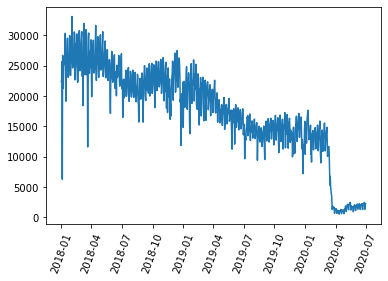

In [13]:
#ridership timeline - daily trip counts; seem to decline and particularly during the pandemics lockdown
plt.plot(dfTaxiDaily['Date'], dfTaxiDaily['trip_count'])
plt.xticks(rotation=70);
plt.show()

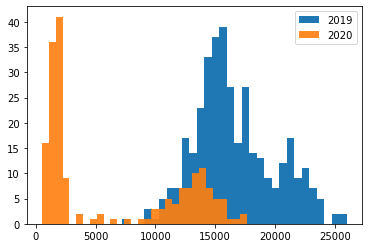

In [14]:
#histograms of daily counts in 2019 and 2018 - distributions look different
plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'].values,bins=30,label='2019')
plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'].values,bins=30,alpha=0.9,label='2020')
#plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'].values,bins=30,alpha=0.5,label='2020')
plt.legend()
plt.show()

In [15]:
## t-test between the 2019 and 2018 distributions
stats.ttest_ind(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'],dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'])

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [16]:
## K-S test
stats.ks_2samp(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'],dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'])

KstestResult(statistic=0.0, pvalue=1.0)

So the hypothesis that 2018 and 2019 daily trip counts follow the same distributions can be rejected beyond any reasonable doubt

In [17]:
#For further analysis select the year 2019
dfTaxiDaily2019 = dfTaxiDaily.loc[dfTaxiDaily['Year']==2019] #daily aggregates
dfTaxi2019 = dfTaxi.loc[dfTaxi['Year']==2019] #individual trips
(dfTaxiDaily2019['trip_count'].sum(),len(dfTaxi2019)) #total trip counts in either dataset

(6050642, 6050642)

## Example 1. Test if weekend ridership is different from weekday

In [18]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<=4
# t-test
stats.ttest_ind(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']>4]['trip_count'],
                dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']<=4]['trip_count'])

Ttest_indResult(statistic=-3.404605179959555, pvalue=0.0007366377048209596)

In [19]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<=4
# KS-test
stats.ks_2samp(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']>4]['trip_count'],
                dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']<=4]['trip_count'])

KstestResult(statistic=0.21198054818744475, pvalue=0.002018094414961258)

Reject the hypothesis that weekends and weekdays follow the same ridership distribution at 95\% significance level

## Example 2. Test if trip speed, duration or distance follow log-normal distributions

<AxesSubplot:>

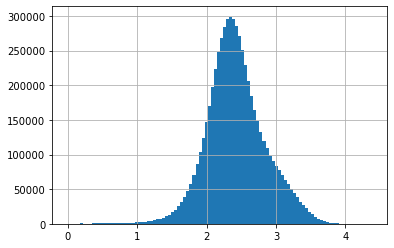

In [20]:
#analyze the overall speed distribution (plot on log-scale)
np.log(dfTaxi2019['speed']).hist(bins=100)

<AxesSubplot:>

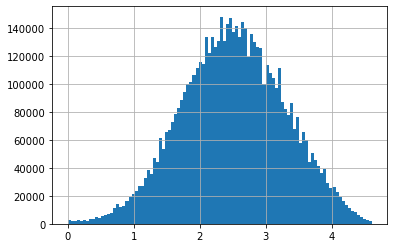

In [21]:
#analyze the overall duration distribution (plot on log-scale)
np.log(dfTaxi2019['trip_duration']).hist(bins=100)

<AxesSubplot:>

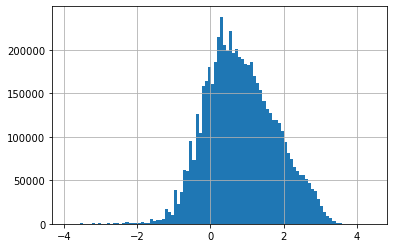

In [22]:
#analyze the overall duration distribution (plot on log-scale)
np.log(dfTaxi2019['trip_distance']).hist(bins=100)

In [23]:
def is_normal(x): #check is the distribution is normal using one-sample KS test and sample mean-std
    return stats.kstest(x,'norm',args=(x.mean(),x.std()))

In [24]:
# is log-speed normally distributed?
is_normal(np.log(dfTaxi2019['speed']))

KstestResult(statistic=0.04112421439353464, pvalue=0.0)

In [25]:
# is log-duration normally distributed?
is_normal(np.log(dfTaxi2019['trip_duration']))

KstestResult(statistic=0.00991038170737979, pvalue=0.0)

In [26]:
# is log-distance normally distributed?
is_normal(np.log(dfTaxi2019['trip_distance']))

KstestResult(statistic=0.038051991909808514, pvalue=0.0)

In [27]:
#so none of those quantities have log-normal distribution (rejecting with 99.9999...% confidence)

In [28]:
#what about daily average trip_count, duration, distance, speed?

In [29]:
is_normal(dfTaxiDaily2019['trip_count']) #does not look normal

KstestResult(statistic=0.08978473661157738, pvalue=0.0052026892522868615)

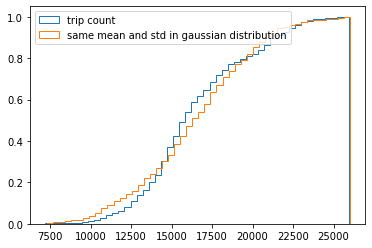

In [30]:
#visualize empiric CDF's for trip-counts
plt.hist(dfTaxiDaily2019['trip_count'].values, 50, density=True, 
         histtype='step',cumulative=True,label='trip count')
plt.hist(np.random.normal(dfTaxiDaily2019['trip_count'].mean(), dfTaxiDaily2019['trip_count'].std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std in gaussian distribution')
plt.legend(loc='upper left')

In [31]:
is_normal(np.log(dfTaxiDaily2019['trip_count'])) #but might be log-normal

KstestResult(statistic=0.05176889942437657, pvalue=0.27245276442567923)

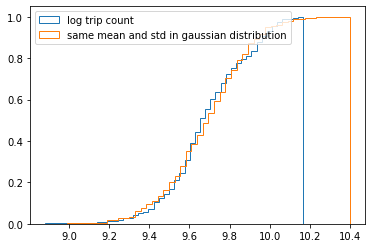

In [32]:
#visualize empiric CDF's for log trip-counts
plt.hist(np.log(dfTaxiDaily2019['trip_count'].values), 50, density=True, 
         histtype='step',cumulative=True,label='log trip count')
plt.hist(np.random.normal(np.log(dfTaxiDaily2019['trip_count']).mean(), np.log(dfTaxiDaily2019['trip_count']).std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std in gaussian distribution')
plt.legend(loc='upper left')

In [33]:
is_normal(dfTaxiDaily2019['trip_duration']) #could be normal

KstestResult(statistic=0.08629102051381854, pvalue=0.008181442632357832)

<AxesSubplot:>

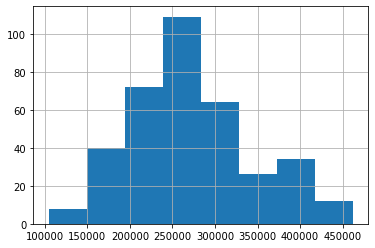

In [34]:
dfTaxiDaily2019['trip_duration'].hist(bins=8)

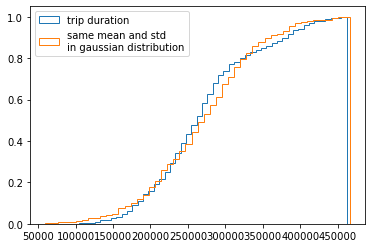

In [35]:
_ = plt.hist(dfTaxiDaily2019['trip_duration'].values, 50, density=True, 
         histtype='step',cumulative=True,label='trip duration')
_ = plt.hist(np.random.normal(dfTaxiDaily2019['trip_duration'].mean(), 
                              dfTaxiDaily2019['trip_duration'].std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std \nin gaussian distribution')
plt.legend(loc='upper left')

In [36]:
is_normal(dfTaxiDaily2019['trip_distance']) #does not look normal

KstestResult(statistic=0.17163545001482727, pvalue=7.163182264727073e-10)

In [37]:
is_normal(np.log(dfTaxiDaily2019['trip_distance'])) #but might be log-normal

KstestResult(statistic=0.12271548280910827, pvalue=3.0054477785862917e-05)

In [38]:
is_normal(dfTaxiDaily2019['speed']) #might be normal

KstestResult(statistic=0.07628804961462687, pvalue=0.02707330147991338)

In [39]:
is_normal(np.log(dfTaxiDaily2019['speed'])) #log-normal even more likely

KstestResult(statistic=0.06791252706897999, pvalue=0.06584459147143595)

## Homework assignment

## Task 1. Travel speed - hours of the day
Traffic and travel speed might vary throughout the day. Select the trips happening on Oct, 1, 2019. a) Compute average travel speed per each hour of the day and visuale as a bar plot. Compare the speed distributions for: b) trip samples within an hour of 9am (Hour=9) and an hour of 10am, c) morning rush hour (two hours of 8 and 9am) and evening rush hour (two hours of 5pm(17) and 6pm(18)). Can you reject the hypothesis that the compared speed samples have the same mean(use t-test) and distribution (use ks-test) at a 95\% significance level?

In [40]:
#get the data of Oct, 1, 2019
dfTaxitask1 = dfTaxi[(dfTaxi['Date']==pd.to_datetime('10/1/2019'))]
dfTaxitask1

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,payment_type,trip_type,congestion_surcharge,Date,Month,Year,DOW,Hour,trip_duration,speed
12506815,2,2019-10-01 00:26:02,2019-10-01 00:39:58,N,1.0,112,196,1.0,5.88,18.00,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,13.933333,25.320574
12506816,1,2019-10-01 00:18:11,2019-10-01 00:22:38,N,1.0,43,263,1.0,0.80,5.00,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,4.450000,10.786517
12506817,1,2019-10-01 00:09:31,2019-10-01 00:24:47,N,1.0,255,228,2.0,7.50,21.50,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,15.266667,29.475983
12506818,1,2019-10-01 00:37:40,2019-10-01 00:41:49,N,1.0,181,181,1.0,0.90,5.50,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,4.150000,13.012048
12506819,2,2019-10-01 00:08:13,2019-10-01 00:17:56,N,1.0,97,188,1.0,2.52,10.00,...,1.0,1.0,0.0,2019-10-01,10,2019,1,0,9.716667,15.560892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12895903,2,2019-10-01 23:02:00,2019-10-01 23:21:00,None,NaN,53,38,NaN,13.01,30.84,...,NaN,NaN,NaN,2019-10-01,10,2019,1,23,19.000000,41.084211
12895904,2,2019-10-01 23:00:00,2019-10-01 23:15:00,None,NaN,252,213,NaN,5.46,26.63,...,NaN,NaN,NaN,2019-10-01,10,2019,1,23,15.000000,21.840000
13430241,2,2019-10-01 00:02:03,2019-10-01 00:03:34,N,1.0,166,166,1.0,0.36,3.50,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,1.516667,14.241758
13430443,2,2019-10-01 00:02:07,2019-10-01 00:12:34,N,1.0,130,205,1.0,2.85,11.00,...,1.0,1.0,0.0,2019-10-01,10,2019,1,0,10.450000,16.363636


In [41]:
#Compute average travel speed per each hour of the day
dfTaxitask1_hour=dfTaxitask1.groupby(by='Hour').agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
dfTaxitask1_hour=dfTaxitask1_hour.sort_values(by='Hour')
dfTaxitask1_hour

,Hour,trip_count,trip_duration,trip_distance
0,0,214,2334.350000,668.85
1,1,127,1381.233333,385.41
2,2,72,782.450000,215.77
3,3,79,923.000000,318.19
4,4,86,1285.066667,507.86
5,5,126,2175.283333,849.78
6,6,250,5009.300000,1538.61
7,7,503,8854.566667,2105.64
8,8,733,12250.116667,2836.71
9,9,840,12839.400000,2979.73


In [42]:
#get the average speed
dfTaxitask1_hour['speed'] = dfTaxitask1_hour['trip_distance'] / dfTaxitask1_hour['trip_duration'] * 60
dfTaxitask1_hour['speed']

0     17.191509
1     16.741994
2     16.545722
3     20.684074
4     23.712077
5     23.439154
6     18.429042
7     14.268163
8     13.893957
9     13.924623
10    14.622849
11    14.104873
12    13.677950
13    13.985810
14    12.604460
15    12.894124
16    12.728742
17    12.637178
18    13.008697
19    13.653545
20    15.042617
21    15.156385
22    15.871392
23    17.740920
Name: speed, dtype: float64

<AxesSubplot:xlabel='Hour'>

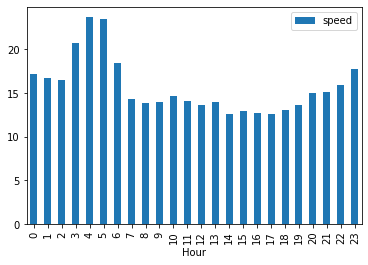

In [43]:
#plot in the bar
dfTaxitask1_hour.plot.bar('Hour','speed')

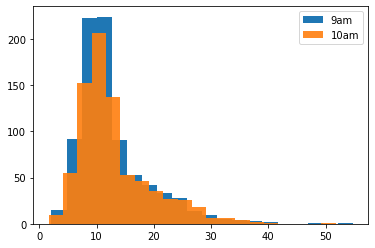

In [44]:
 #Compare the speed distributions for: b) trip samples within an hour of 9am (Hour=9) and an hour of 10am
plt.hist(dfTaxitask1.loc[dfTaxitask1['Hour']==9]['speed'].values,bins=20,label='9am')
plt.hist(dfTaxitask1.loc[dfTaxitask1['Hour']==10]['speed'].values,bins=20,alpha=0.9,label='10am')
plt.legend()
plt.show()

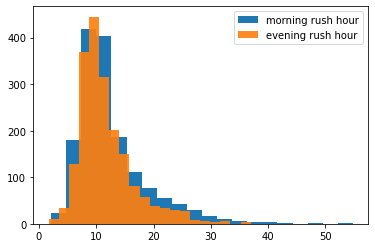

In [45]:
#orning rush hour (two hours of 8 and 9am) and evening rush hour (two hours of 5pm(17) and 6pm(18))
plt.hist(dfTaxitask1.loc[dfTaxitask1['Hour'].isin([8,9])]['speed'].values,bins=20,label='morning rush hour')
plt.hist(dfTaxitask1.loc[dfTaxitask1['Hour'].isin([17,18])]['speed'].values,bins=20,alpha=0.9,label='evening rush hour')
plt.legend()
plt.show()

In [46]:
#Can you reject the hypothesis that the compared speed samples have the same mean(use t-test) and distribution (use ks-test) at a 95% significance level?

#t-test for 9 am and 10 am 
stats.ttest_ind(dfTaxitask1.loc[dfTaxitask1['Hour']==9]['speed'],
                dfTaxitask1.loc[dfTaxitask1['Hour']==10]['speed'])
#


Ttest_indResult(statistic=-1.173277394807621, pvalue=0.2408567402829922)

In [47]:
#ks-test for 9 am and 10 am 
stats.ks_2samp(dfTaxitask1.loc[dfTaxitask1['Hour']==9]['speed'],
                dfTaxitask1.loc[dfTaxitask1['Hour']==10]['speed'])
#

KstestResult(statistic=0.04866545344252351, pvalue=0.2793212653142807)

In [48]:
#t-test for morning rush hour and evening rush hour
stats.ttest_ind(dfTaxitask1.loc[dfTaxitask1['Hour'].isin([8,9])]['speed'],
                dfTaxitask1.loc[dfTaxitask1['Hour'].isin([17,18])]['speed'])

Ttest_indResult(statistic=5.316218844376528, pvalue=1.1253493376433041e-07)

In [49]:
#ks-test for morning rush hour and evening rush hour
stats.ks_2samp(dfTaxitask1.loc[dfTaxitask1['Hour'].isin([8,9])]['speed'],
                dfTaxitask1.loc[dfTaxitask1['Hour'].isin([17,18])]['speed'])
#

KstestResult(statistic=0.06860517517057287, pvalue=0.0005164093592973096)

## Task 2. Travel speed - days of the week
Traffic and travel speed also vary during different weekdays. a) Compute average travel speed per each of the 7 days of the week (among all the individual trips happening on Mondays, Tuesdays, Wednesdays etc); visualize those as a bar plot. Then compute average travel speed per each day of the year and perform a pairwise comparison between the distributions of the daily speed averages within different days of the week (i.e. distribution of all Mondays vs all Tuesdays etc). Compute p-value of the ks-test for each pair of the different weekdays and compare with 5\%. As a results we are expecting a 7*7 pandas dataframe filled with "reject" (if p-value below 5\%), "keep" (if p-value above 5\%) and "-" on the diagonal.

In [50]:

dfTaxitask2=dfTaxi.groupby(by='DOW').agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
dfTaxitask2=dfTaxitask2.sort_values(by='DOW')
dfTaxitask2

,DOW,trip_count,trip_duration,trip_distance
0,0,2090514,3.271465e+07,7346729.35
1,1,2200540,3.592647e+07,7768936.63
2,2,2277914,3.744882e+07,8044210.21
3,3,2365125,3.947172e+07,8263397.93
4,4,2524814,4.090780e+07,8553861.26
5,5,2419939,3.488742e+07,8104591.86
6,6,2002537,2.802968e+07,6997613.31


In [51]:
#Compute average travel speed per each of the 7 days of the week 
dfTaxitask2['speed']=dfTaxitask2['trip_distance'] / dfTaxitask2['trip_duration'] * 60
dfTaxitask2

,DOW,trip_count,trip_duration,trip_distance,speed
0,0,2090514,3.271465e+07,7346729.35,13.474200
1,1,2200540,3.592647e+07,7768936.63,12.974729
2,2,2277914,3.744882e+07,8044210.21,12.888325
3,3,2365125,3.947172e+07,8263397.93,12.560989
4,4,2524814,4.090780e+07,8553861.26,12.546060
5,5,2419939,3.488742e+07,8104591.86,13.938421
6,6,2002537,2.802968e+07,6997613.31,14.979006


<AxesSubplot:xlabel='DOW'>

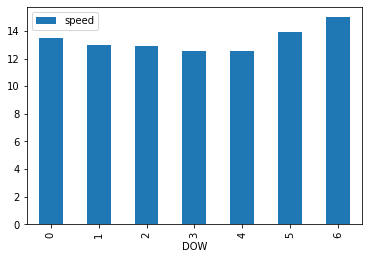

In [52]:
#visualize those as a bar plot
dfTaxitask2.plot.bar('DOW','speed')

In [53]:

task2daily = dfTaxi.groupby(['Date','DOW']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()

task2daily = task2daily.sort_values(by='Date')

task2daily['speed'] = task2daily['trip_distance'] / task2daily['trip_duration'] * 60
task2daily

,Date,DOW,trip_count,trip_duration,trip_distance,speed
0,2018-01-01,0,22384,263853.966667,67911.34,15.442938
1,2018-01-02,1,22583,274362.416667,59493.64,13.010595
2,2018-01-03,2,25673,341670.100000,69394.22,12.186180
3,2018-01-04,3,6297,80896.516667,16403.10,12.165987
4,2018-01-05,4,26727,341303.233333,64290.25,11.302017
...,...,...,...,...,...,...
907,2020-06-26,4,2470,45874.233333,12314.68,16.106663
908,2020-06-27,5,1691,25746.750000,7642.07,17.809013
909,2020-06-28,6,1341,20931.033333,6713.17,19.243684
910,2020-06-29,0,2210,40750.166667,11496.92,16.927911


In [54]:
#perform a pairwise comparison between the distributions of the daily speed averages within different days of the week
#tttest


test2=pd.DataFrame(columns=['Monday','Tuesday','Wednesday','Thuesday','Friday','Saturday','Sunday'],index=['Monday','Tuesday','Wednesday','Thuesday','Friday','Saturday','Sunday'])


for i in range(0,7):
    for j in range(0,7):
        result=stats.ks_2samp(task2daily.loc[task2daily['DOW']==i]['speed'],
               task2daily.loc[task2daily['DOW']==j]['speed'])
        if result.pvalue <= 0.05:
            test2.iloc[i,j]='reject'
        elif (result.pvalue > 0.05) & (result.pvalue<1):
            test2.iloc[i,j]='keep'
        elif result.pvalue >= 1:
             test2.iloc[i,j]='-'
test2


,Monday,Tuesday,Wednesday,Thuesday,Friday,Saturday,Sunday
Monday,-,reject,reject,reject,reject,reject,reject
Tuesday,reject,-,keep,reject,reject,reject,reject
Wednesday,reject,keep,-,reject,reject,reject,reject
Thuesday,reject,reject,reject,-,keep,reject,reject
Friday,reject,reject,reject,keep,-,reject,reject
Saturday,reject,reject,reject,reject,reject,-,reject
Sunday,reject,reject,reject,reject,reject,reject,-


## Task 3. Trip speeds per borough.

For the day of Oct, 1, 2019 compute the average trip speed in Brooklyn, Queens and Bronx (by pickup). Then compare the samples of the trip speeds in Brooklyn, Queens and Bronx on that day using t-test and ks-test (pairwise comparison). Fill two 3x3 pandas dataframes (one for t-test, one for ks-test) with p-values for each pair of boroughs. Can we reject the null hypothesis that speed mean/distributions within each pair of boroughs is is similar?

HINT: Download taxizone geojson from 'https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON' to define borough for each pickup taxi zone.

In [55]:
# download taxizone map
file = 'taxizone.geojson'
url = 'https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON'
#urllib.request.urlretrieve(url,'Data/TLC/'+file)
task3= gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON')
task3

,shape_area,objectid,shape_leng,location_id,zone,borough,geometry
0,0.0007823067885,1,0.116357453189,1,Newark Airport,EWR,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ..."
1,0.00486634037837,2,0.43346966679,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,0.000314414156821,3,0.0843411059012,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ..."
3,0.000111871946192,4,0.0435665270921,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ..."
4,0.000497957489363,5,0.0921464898574,5,Arden Heights,Staten Island,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ..."
...,...,...,...,...,...,...,...
258,0.000168611097013,256,0.0679149669603,256,Williamsburg (South Side),Brooklyn,"MULTIPOLYGON (((-73.95834 40.71331, -73.95681 ..."
259,0.000394552487366,259,0.126750305191,259,Woodlawn/Wakefield,Bronx,"MULTIPOLYGON (((-73.85107 40.91037, -73.85207 ..."
260,0.000422345326907,260,0.133514154636,260,Woodside,Queens,"MULTIPOLYGON (((-73.90175 40.76078, -73.90147 ..."
261,0.0000343423231652,261,0.0271204563616,261,World Trade Center,Manhattan,"MULTIPOLYGON (((-74.01333 40.70503, -74.01327 ..."


In [56]:
#get the data of  Oct, 1, 2019 compute the average trip speed in Brooklyn, Queens and Bronx (by pickup).
dfTaxitask3 = dfTaxi[(dfTaxi['Date']==pd.to_datetime('10/1/2019'))]
dfTaxitask3['Date']= pd.to_datetime(dfTaxitask3.Date)
dfTaxitask3['lpep_pickup_datetime']= pd.to_datetime(dfTaxitask3.lpep_pickup_datetime)
dfTaxitask3['lpep_dropoff_datetime']= pd.to_datetime(dfTaxitask3.lpep_dropoff_datetime)
dfTaxitask3.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,payment_type,trip_type,congestion_surcharge,Date,Month,Year,DOW,Hour,trip_duration,speed
12506815,2,2019-10-01 00:26:02,2019-10-01 00:39:58,N,1.0,112,196,1.0,5.88,18.0,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,13.933333,25.320574
12506816,1,2019-10-01 00:18:11,2019-10-01 00:22:38,N,1.0,43,263,1.0,0.80,5.0,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,4.450000,10.786517
12506817,1,2019-10-01 00:09:31,2019-10-01 00:24:47,N,1.0,255,228,2.0,7.50,21.5,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,15.266667,29.475983
12506818,1,2019-10-01 00:37:40,2019-10-01 00:41:49,N,1.0,181,181,1.0,0.90,5.5,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,4.150000,13.012048
12506819,2,2019-10-01 00:08:13,2019-10-01 00:17:56,N,1.0,97,188,1.0,2.52,10.0,...,1.0,1.0,0.0,2019-10-01,10,2019,1,0,9.716667,15.560892


In [57]:
task3.location_id

0        1
1        2
2        3
3        4
4        5
      ... 
258    256
259    259
260    260
261    261
262    262
Name: location_id, Length: 263, dtype: object

In [58]:
task3['location_id']=task3['location_id'].astype(np.int64)
task3.location_id

0        1
1        2
2        3
3        4
4        5
      ... 
258    256
259    259
260    260
261    261
262    262
Name: location_id, Length: 263, dtype: int64

In [59]:
dfTaxitask3.PULocationID

12506815    112
12506816     43
12506817    255
12506818    181
12506819     97
           ... 
12895903     53
12895904    252
13430241    166
13430443    130
13430481    256
Name: PULocationID, Length: 13579, dtype: int64

In [60]:
newtask3=pd.merge(dfTaxitask3,task3,how='inner',left_on='PULocationID',right_on='location_id')
newtask3

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,Hour,trip_duration,speed,shape_area,objectid,shape_leng,location_id,zone,borough,geometry
0,2,2019-10-01 00:26:02,2019-10-01 00:39:58,N,1.0,112,196,1.0,5.88,18.00,...,0,13.933333,25.320574,0.000462068671429,112,0.107267875765,112,Greenpoint,Brooklyn,"MULTIPOLYGON (((-73.95440 40.73911, -73.95428 ..."
1,2,2019-10-01 00:27:31,2019-10-01 00:46:59,N,1.0,112,37,5.0,3.84,15.50,...,0,19.466667,11.835616,0.000462068671429,112,0.107267875765,112,Greenpoint,Brooklyn,"MULTIPOLYGON (((-73.95440 40.73911, -73.95428 ..."
2,2,2019-10-01 02:18:24,2019-10-01 02:21:13,N,1.0,112,112,5.0,0.56,4.00,...,2,2.816667,11.928994,0.000462068671429,112,0.107267875765,112,Greenpoint,Brooklyn,"MULTIPOLYGON (((-73.95440 40.73911, -73.95428 ..."
3,2,2019-10-01 02:41:37,2019-10-01 02:49:18,N,1.0,112,226,4.0,1.81,8.00,...,2,7.683333,14.134490,0.000462068671429,112,0.107267875765,112,Greenpoint,Brooklyn,"MULTIPOLYGON (((-73.95440 40.73911, -73.95428 ..."
4,2,2019-10-01 08:52:53,2019-10-01 09:08:51,N,1.0,112,233,1.0,3.39,14.50,...,8,15.966667,12.739040,0.000462068671429,112,0.107267875765,112,Greenpoint,Brooklyn,"MULTIPOLYGON (((-73.95440 40.73911, -73.95428 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13590,2,2019-10-01 16:19:00,2019-10-01 16:36:00,None,NaN,143,244,NaN,5.92,42.95,...,16,17.000000,20.894118,0.00015109426901,143,0.0541798538849,143,Lincoln Square West,Manhattan,"MULTIPOLYGON (((-73.98163 40.78033, -73.98152 ..."
13591,2,2019-10-01 17:05:00,2019-10-01 17:37:00,None,NaN,143,119,NaN,7.79,35.95,...,17,32.000000,14.606250,0.00015109426901,143,0.0541798538849,143,Lincoln Square West,Manhattan,"MULTIPOLYGON (((-73.98163 40.78033, -73.98152 ..."
13592,2,2019-10-01 17:49:00,2019-10-01 18:22:00,None,NaN,232,259,NaN,16.86,48.93,...,17,33.000000,30.654545,0.000216049973456,232,0.0614709085331,232,Two Bridges/Seward Park,Manhattan,"MULTIPOLYGON (((-73.97636 40.71913, -73.97551 ..."
13593,2,2019-10-01 21:44:00,2019-10-01 22:00:00,None,NaN,142,158,NaN,2.89,21.99,...,21,16.000000,10.837500,0.0000756537920738,142,0.0381758942321,142,Lincoln Square East,Manhattan,"MULTIPOLYGON (((-73.98148 40.76773, -73.98155 ..."


In [61]:
#filter the three bough data
newtask3=newtask3[newtask3['borough'].isin(['Brooklyn','Queens','Bronx'])]
newtask3

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,Hour,trip_duration,speed,shape_area,objectid,shape_leng,location_id,zone,borough,geometry
0,2,2019-10-01 00:26:02,2019-10-01 00:39:58,N,1.0,112,196,1.0,5.88,18.00,...,0,13.933333,25.320574,0.000462068671429,112,0.107267875765,112,Greenpoint,Brooklyn,"MULTIPOLYGON (((-73.95440 40.73911, -73.95428 ..."
1,2,2019-10-01 00:27:31,2019-10-01 00:46:59,N,1.0,112,37,5.0,3.84,15.50,...,0,19.466667,11.835616,0.000462068671429,112,0.107267875765,112,Greenpoint,Brooklyn,"MULTIPOLYGON (((-73.95440 40.73911, -73.95428 ..."
2,2,2019-10-01 02:18:24,2019-10-01 02:21:13,N,1.0,112,112,5.0,0.56,4.00,...,2,2.816667,11.928994,0.000462068671429,112,0.107267875765,112,Greenpoint,Brooklyn,"MULTIPOLYGON (((-73.95440 40.73911, -73.95428 ..."
3,2,2019-10-01 02:41:37,2019-10-01 02:49:18,N,1.0,112,226,4.0,1.81,8.00,...,2,7.683333,14.134490,0.000462068671429,112,0.107267875765,112,Greenpoint,Brooklyn,"MULTIPOLYGON (((-73.95440 40.73911, -73.95428 ..."
4,2,2019-10-01 08:52:53,2019-10-01 09:08:51,N,1.0,112,233,1.0,3.39,14.50,...,8,15.966667,12.739040,0.000462068671429,112,0.107267875765,112,Greenpoint,Brooklyn,"MULTIPOLYGON (((-73.95440 40.73911, -73.95428 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13557,2,2019-10-01 09:16:00,2019-10-01 09:40:00,None,NaN,59,95,NaN,12.59,34.85,...,9,24.000000,31.475000,0.0000628765230648,59,0.0377948070893,59,Crotona Park,Bronx,"MULTIPOLYGON (((-73.88942 40.83942, -73.88869 ..."
13561,2,2019-10-01 09:59:00,2019-10-01 10:17:00,None,NaN,64,135,NaN,7.97,32.61,...,9,18.000000,26.566667,0.00105790284614,64,0.18445188474,64,Douglaston,Queens,"MULTIPOLYGON (((-73.74412 40.77864, -73.74154 ..."
13562,2,2019-10-01 18:12:00,2019-10-01 18:32:00,None,NaN,64,92,NaN,8.61,26.86,...,18,20.000000,25.830000,0.00105790284614,64,0.18445188474,64,Douglaston,Queens,"MULTIPOLYGON (((-73.74412 40.77864, -73.74154 ..."
13582,2,2019-10-01 13:01:00,2019-10-01 13:23:00,None,NaN,73,122,NaN,6.19,27.81,...,13,22.000000,16.881818,0.000291799754395,73,0.0853020209129,73,East Flushing,Queens,"MULTIPOLYGON (((-73.79567 40.75024, -73.79645 ..."


In [62]:
#calculate the average speed
task3average = newtask3.groupby(['borough']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
task3average['speed'] = task3average['trip_distance'] / task3average['trip_duration'] * 60
task3average

,borough,trip_count,trip_duration,trip_distance,speed
0,Bronx,1013,21668.050000,6101.52,16.895438
1,Brooklyn,3733,68969.366667,15933.62,13.861476
2,Queens,3576,51916.833333,12954.61,14.971572


In [63]:
#tttest
boroughs=['Brooklyn', 'Queens','Bronx']

test3=pd.DataFrame(columns=['Brooklyn','Queens','Bronx'],index=['Brooklyn','Queens','Bronx'])


for i in range(0,3):
    for j in range(0,3):
        result=stats.ttest_ind(newtask3.loc[newtask3['borough']==boroughs[i]]['speed'],
               newtask3.loc[newtask3['borough']==boroughs[j]]['speed'])
        if result.pvalue <= 0.05:
            test3.iloc[i,j]='reject'
        elif (result.pvalue > 0.05) & (result.pvalue<1):
            test3.iloc[i,j]='keep'
        elif result.pvalue >= 1:
             test3.iloc[i,j]='-'
test3

,Brooklyn,Queens,Bronx
Brooklyn,-,reject,reject
Queens,reject,-,reject
Bronx,reject,reject,-


In [64]:
#ks-test
boroughs=['Brooklyn', 'Queens','Bronx']

test3=pd.DataFrame(columns=['Brooklyn','Queens','Bronx'],index=['Brooklyn','Queens','Bronx'])


for i in range(0,3):
    for j in range(0,3):
        result=stats.ks_2samp(newtask3.loc[newtask3['borough']==boroughs[i]]['speed'],
               newtask3.loc[newtask3['borough']==boroughs[j]]['speed'])
        if result.pvalue <= 0.05:
            test3.iloc[i,j]='reject'
        elif (result.pvalue > 0.05) & (result.pvalue<1):
            test3.iloc[i,j]='keep'
        elif result.pvalue >= 1:
             test3.iloc[i,j]='-'
test3

,Brooklyn,Queens,Bronx
Brooklyn,-,reject,reject
Queens,reject,-,reject
Bronx,reject,reject,-


# Task 4. Ridership drop during pandemics
No doubt that 2020 saw a large drop in ridership but how can we assess it? Keep in mind that we don't have the full year, the drop just started in March and there is also a general decline in taxi ridership, so we need a way to distinguish pandemics-related drop from the general trend. In order to account for it, normalize 2020 daily ridership data by the same day's 30-days rolling average (15 days before/after to smoothen out the effect of weekly variations within the baseline) in 2019, and compare the daily ratios of ridership after the shelter in place order (Mar 20th till June, 30th, 2020) and before (Jan, 16-Mar, 20th, 2020). Report p-values of ks-test and t-test. Can we reject the null hypothesis that daily ridership ratio average/distribution after March, 20, 2020 is the same as before? For comparison and to provide a baseline for evaluating results of the hypothesis testing perform the same analysis for the same periods of 2019. Can we reject the null hypothesis that daily ridership ratio average/distribution after March, 20, 2019 is the same as before?

In [65]:
#get the data between Mar 20th and June, 30th, 2020
task4_2020_3_6=dfTaxi[(dfTaxi['Date']<=pd.to_datetime('6/30/2020')) & (dfTaxi['Date']>=pd.to_datetime('3/1/2020'))]
task4_2020_3_6 = task4_2020_3_6.groupby(['Year','Month','DOW','Date']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
task4_2020_3_6 = task4_2020_3_6.sort_values(by='Date')
task4_2020_3_6['speed'] = task4_2020_3_6['trip_distance'] / task4_2020_3_6['trip_duration'] * 60

#cal the rolling 15
task4_2020_3_6['Rolling30'] = task4_2020_3_6['trip_count'].rolling(30,center=True).mean()
#first 15 is empty
task4_2020_3_6=task4_2020_3_6[(task4_2020_3_6['Date']<=pd.to_datetime('6/15/2020')) & (task4_2020_3_6['Date']>=pd.to_datetime('4/4/2020'))]
task4_2020_3_6=task4_2020_3_6.dropna(subset=['Rolling30'])
task4_2020_3_6.reset_index()
task4_2020_3_6

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,Rolling30
53,2020,4,5,2020-04-04,1064,13850.333333,4451.54,19.284186,1322.266667
57,2020,4,6,2020-04-05,672,9077.050000,3242.25,21.431522,1217.700000
31,2020,4,0,2020-04-06,1178,16422.916667,5687.18,20.777722,1177.700000
35,2020,4,1,2020-04-07,1065,15347.933333,5283.44,20.654664,1167.966667
40,2020,4,2,2020-04-08,1081,15411.716667,5259.28,20.475123,1147.200000
...,...,...,...,...,...,...,...,...,...
107,2020,6,3,2020-06-11,2051,35193.050000,10486.58,17.878382,1931.933333
111,2020,6,4,2020-06-12,2214,42143.383333,12206.77,17.378913,1947.233333
115,2020,6,5,2020-06-13,1697,26440.233333,7859.56,17.835455,1939.933333
119,2020,6,6,2020-06-14,1311,20843.900000,6747.18,19.422028,1916.033333


In [66]:
#for the same get the data
#get the data between jan 1 and march 2020
task4_2020_1_3=dfTaxi[(dfTaxi['Date']<=pd.to_datetime('3/20/2020')) & (dfTaxi['Date']>=pd.to_datetime('1/16/2020'))]
task4_2020_1_3 = task4_2020_1_3.groupby(['Year','Month','DOW','Date']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
task4_2020_1_3['speed'] = task4_2020_1_3['trip_distance'] / task4_2020_1_3['trip_duration'] * 60

#cal the rolling 15
task4_2020_1_3['Rolling30'] = task4_2020_1_3['trip_count'].rolling(30,center=True).mean()
#first 15 is empty
task4_2020_1_3=task4_2020_1_3[(task4_2020_1_3['Date']<=pd.to_datetime('3/5/2020')) & (task4_2020_1_3['Date']>=pd.to_datetime('2/1/2020'))]
task4_2020_1_3=task4_2020_1_3.dropna(subset=['Rolling30'])

task4_2020_1_3=task4_2020_1_3.sort_values(by='Date')
task4_2020_1_3

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,Rolling30
36,2020,2,5,2020-02-01,12410,171041.066667,42034.93,14.745557,12688.466667
41,2020,2,6,2020-02-02,11318,155694.233333,40678.39,15.676261,12333.766667
16,2020,2,0,2020-02-03,12750,200905.400000,45921.91,13.714488,13194.700000
20,2020,2,1,2020-02-04,13241,214757.966667,49131.26,13.726502,13445.600000
24,2020,2,2,2020-02-05,14035,221809.183333,50230.18,13.587403,13346.133333
28,2020,2,3,2020-02-06,14045,231327.100000,49681.21,12.885964,13128.866667
32,2020,2,4,2020-02-07,15233,242367.583333,51541.98,12.759622,13046.566667
37,2020,2,5,2020-02-08,13109,188308.766667,46187.17,14.716416,12714.633333
42,2020,2,6,2020-02-09,10994,153936.750000,41139.33,16.034896,12024.500000
17,2020,2,0,2020-02-10,12962,210992.000000,45591.23,12.964822,13283.800000


In [67]:
#get the data between Mar 20th and June, 30th, 2019
task4_2019_3_6=dfTaxi[(dfTaxi['Date']<=pd.to_datetime('6/30/2019')) & (dfTaxi['Date']>=pd.to_datetime('3/1/2019'))]
task4_2019_3_6 = task4_2019_3_6.groupby(['Year','Month','DOW','Date']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
task4_2019_3_6 = task4_2019_3_6.sort_values(by='Date')
task4_2019_3_6['speed'] = task4_2019_3_6['trip_distance'] / task4_2019_3_6['trip_duration'] * 60

#cal the rolling 15
task4_2019_3_6['Rolling30'] = task4_2019_3_6['trip_count'].rolling(30,center=True).mean()
#first 15 is empty
task4_2019_3_6=task4_2019_3_6[(task4_2019_3_6['Date']<=pd.to_datetime('6/15/2019')) & (task4_2019_3_6['Date']>=pd.to_datetime('4/4/2019'))]
task4_2019_3_6=task4_2019_3_6.dropna(subset=['Rolling30'])
task4_2019_3_6


,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,Rolling30
45,2019,4,3,2019-04-04,21641,411873.300000,86396.58,12.585897,19481.333333
49,2019,4,4,2019-04-05,22614,408812.033333,83563.43,12.264330,19397.333333
53,2019,4,5,2019-04-06,20640,335869.316667,77240.39,13.798293,19291.800000
57,2019,4,6,2019-04-07,17597,282728.183333,72062.09,15.292870,19082.133333
32,2019,4,0,2019-04-08,17226,276908.850000,60654.16,13.142410,18922.800000
...,...,...,...,...,...,...,...,...,...
97,2019,6,1,2019-06-11,15782,274519.266667,55809.86,12.198020,16249.500000
101,2019,6,2,2019-06-12,16705,283955.116667,56862.81,12.015169,16421.800000
105,2019,6,3,2019-06-13,17829,301409.583333,59716.13,11.887372,16432.966667
109,2019,6,4,2019-06-14,18080,310185.350000,60897.62,11.779593,16458.266667


In [68]:
#for the same get the data
#get the data between jan 1 and march 2019
task4_2019_1_3=dfTaxi[(dfTaxi['Date']<=pd.to_datetime('3/20/2019')) & (dfTaxi['Date']>=pd.to_datetime('1/16/2019'))]
task4_2019_1_3 = task4_2019_1_3.groupby(['Year','Month','DOW','Date']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
task4_2019_1_3['speed'] = task4_2020_1_3['trip_distance'] / task4_2019_1_3['trip_duration'] * 60

#cal the rolling 15
task4_2019_1_3['Rolling30'] = task4_2019_1_3['trip_count'].rolling(30,center=True).mean()
#first 15 is empty
task4_2019_1_3=task4_2019_1_3[(task4_2019_1_3['Date']<=pd.to_datetime('3/5/2019')) & (task4_2019_1_3['Date']>=pd.to_datetime('2/1/2019'))]
task4_2019_1_3=task4_2019_1_3.dropna(subset=['Rolling30'])
task4_2019_1_3=task4_2019_1_3.sort_values(by='Date')
task4_2019_1_3

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,Rolling30
32,2019,2,4,2019-02-01,25971,444986.916667,97478.30,6.949685,20965.666667
36,2019,2,5,2019-02-02,22937,342650.300000,82569.34,7.360553,21114.466667
40,2019,2,6,2019-02-03,19194,287419.100000,76899.23,9.669810,21181.100000
16,2019,2,0,2019-02-04,21282,390948.216667,89979.10,7.047774,21453.433333
20,2019,2,1,2019-02-05,21081,384734.116667,91901.70,7.662111,21727.900000
24,2019,2,2,2019-02-06,23739,438233.800000,96530.58,6.877176,21685.700000
28,2019,2,3,2019-02-07,23212,436063.500000,96575.39,6.835868,21216.000000
33,2019,2,4,2019-02-08,25251,455669.400000,98124.95,6.948108,20958.533333
37,2019,2,5,2019-02-09,23176,345352.966667,84734.91,8.024342,21239.466667
41,2019,2,6,2019-02-10,18439,273535.166667,72829.17,8.922814,21210.500000


In [69]:
#ratio from 3-6
ration3_6=[]
for i in range(73):
    ratio1=task4_2020_3_6.iloc[i,8]/task4_2019_3_6.iloc[i,8]
    ration3_6.append(ratio1)
ration3_6

[0.06787351995072206,
 0.06277667033269178,
 0.0610466623124851,
 0.06120734229576008,
 0.06062527744308454,
 0.059791786385382045,
 0.05921273475733645,
 0.05843665234031484,
 0.05671086563360233,
 0.05719300185673033,
 0.05908176363688811,
 0.05982186982179714,
 0.06031259198424321,
 0.06133761346348422,
 0.061684220124925915,
 0.060961038866133445,
 0.0625221633241771,
 0.06560205312996006,
 0.06799229913675807,
 0.07010016461804469,
 0.07191748587177103,
 0.07271758109082964,
 0.07295734688225886,
 0.0754193006866096,
 0.07929735745469609,
 0.08236105787658107,
 0.08437757397275196,
 0.08695253066516734,
 0.08807192853019769,
 0.08786443761561863,
 0.08971236338836962,
 0.09214579990376118,
 0.09368687937395881,
 0.09495864642162406,
 0.09578994534933152,
 0.0958211425306291,
 0.09529367491456331,
 0.09609263886219489,
 0.09932506756114452,
 0.10206581428315832,
 0.10289134167279862,
 0.10391112261018531,
 0.10385982782092593,
 0.10257975012901693,
 0.10356433035372012,
 0.10596308

In [77]:
#ratio from 1-3 feb has 28 days in 2019 but 29 days in 2020, and have some missing values so we have 28 pairs
ration1_3=[]
for i in range(28):
    ration2=task4_2020_1_3.iloc[i,8]/task4_2019_1_3.iloc[i,8]
    ration1_3.append(ration2)
ration1_3

[0.605202155905687,
 0.5841382054010362,
 0.6229468724476067,
 0.6267341824074779,
 0.6142394494329103,
 0.6054158577618738,
 0.6149399824032178,
 0.60665663627862,
 0.566139451084773,
 0.6262841517173098,
 0.6298245068627298,
 0.6088986083377137,
 0.6018873583904386,
 0.6110317958870297,
 0.6011730436648699,
 0.5682001779107743,
 0.626434623712437,
 0.6218197073267033,
 0.6074603128439285,
 0.6059753840057949,
 0.6175862571894202,
 0.5887721173351209,
 0.5615322550263089,
 0.6299326644091126,
 0.6179218186007218,
 0.6027286434008752,
 0.6144448251423313,
 0.6156200810157691]

In [78]:
#ttest and ktest for 2020
stats.ttest_ind(ration3_6,ration1_3)

Ttest_indResult(statistic=-8.43804425510777, pvalue=6.180914067580782e-14)

In [79]:
stats.ks_2samp(ration3_6,ration1_3)

KstestResult(statistic=0.7227722772277227, pvalue=8.541944929163492e-12)

In [76]:
#thus we reject the null hypothesis based on the p value